In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-25 03:53:43.051050: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 03:53:43.076341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-25 03:53:44.222020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:53:44.226139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:53:44.226271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [3]:
dataset_name = 'crypto_minute'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params



Using output folder .


2023-11-25 03:53:49.886468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:53:49.886738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:53:49.886916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_minute ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.5
hidden_layer_size: 10
learning_rate: 0.01
minibatch_size: 64
max_gradient_norm: 100.0
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_minute/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.5
# hidden_layer_size = 10
# learning_rate = 0.01
# max_gradient_norm = 100.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_minute/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('symbol_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('ts', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('row_id', <DataTypes.RE

2023-11-25 03:53:50.677510: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:50.679756: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-25 03:53:50.891324: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_8/bias/Assign' id:385 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_8/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_8/bias, TemporalFusionTransformer/time_distributed_8/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:50.901832: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_12/stack_1' id:398 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_12/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-25 03:53:51.096202: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:633 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 4>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:51.102350: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:634 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutatio

2023-11-25 03:53:51.671933: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1723 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:51.692160: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_17/bias/Assign' id:1823 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_17/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_17/bias, TemporalFusionTransformer/time_distributed_17/bia

2023-11-25 03:53:52.378997: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_34/kernel/Assign' id:2621 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_34/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_34/kernel, TemporalFusionTransformer/time_distributed_34/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:52.420176: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_28/stack_1' id:2785 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_28/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-25 03:53:53.229442: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_32/stack_2' id:3558 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_32/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:53.351269: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_55/bias/Assign' id:3621 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_55/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_55/bias, TemporalFusionTransformer/time

2023-11-25 03:53:54.643591: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_20/beta/Assign' id:4676 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_20/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_20/beta, TemporalFusionTransformer/layer_normalization_20/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:54.722137: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:4715 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, 

2023-11-25 03:53:56.045838: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_40/stack_1' id:5361 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_40/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:56.109042: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_40/stack_2' id:5362 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_40/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutat

2023-11-25 03:53:57.558182: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/num_cols' id:6245 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/num_cols}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:53:57.634084: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/padding_value' id:6246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/padding_value}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 17)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 17)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 10)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 dropout_2 (Dropout)         (None, 10)                   0         ['dense_27[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 31, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 31, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
                                                                    ]']                           
          

                                                                     'time_distributed_13[0][0]', 
                                                                     'time_distributed_14[0][0]'] 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 10, 1)]          0         ['time_distributed_15[0][0]'] 
 Transformer/stack_3 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 10, 1)]          0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
          

 26 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 27 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 28 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 time_distributed_42 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_29[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_46 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_30[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_50 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_31[0][
          

2023-11-25 03:53:58.732389: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:6872 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 istributed)                                                        ansformer/strided_slice_36[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_74 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_37[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_78 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_38[0][
                                                                    0]']                          
          

 istributed)                                                                                      
                                                                                                  
 time_distributed_47 (TimeD  (None, 30, 10)               110       ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_51 (TimeD  (None, 30, 10)               110       ['activation_16[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_55 (TimeD  (None, 30, 10)               110       ['activation_17[0][0]']       
 istributed)                                                                                      
          

 time_distributed_93 (TimeD  (None, 1, 10)                110       ['activation_27[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_16 (TimeD  (None, 30, 16)               2576      ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape[0][0]']     
                                                                                                  
 multiply_7 (Multiply)       (None, 30, 16)               0         ['time_distributed_20[0][0]', 
                                                                     'time_distributed_21[0][0]'] 
                                                                                                  
 time_distributed_24 (TimeD  (None, 30, 10)               110       ['dropout_7[0][0]']           
 istribute

                                                                                                  
 time_distributed_73 (TimeD  (None, 30, 10)               110       ['dropout_19[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_76 (TimeD  (None, 30, 10)               110       ['dropout_20[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_77 (TimeD  (None, 30, 10)               110       ['dropout_20[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_dist

                                                                     'time_distributed_85[0][0]'] 
                                                                                                  
 dense_35 (Dense)            (None, 10)                   110       ['activation_5[0][0]']        
                                                                                                  
 dense_39 (Dense)            (None, 10)                   110       ['activation_6[0][0]']        
                                                                                                  
 time_distributed_86 (TimeD  (None, 1, 1)                 11        ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 multiply_25 (Multiply)      (None, 1, 1)                 0         ['time_distributed_90[0][0]', 
          

                                                                    0]',                          
                                                                     'multiply_20[0][0]']         
                                                                                                  
 add_20 (Add)                (None, 30, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_37[0][
                                                                    0]',                          
                                                                     'multiply_21[0][0]']         
                                                                                                  
 add_21 (Add)                (None, 30, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_38[0][
          

 dense_40 (Dense)            (None, 10)                   110       ['dropout_5[0][0]']           
                                                                                                  
 dense_41 (Dense)            (None, 10)                   110       ['dropout_5[0][0]']           
                                                                                                  
 layer_normalization_23 (La  (None, 1, 1)                 2         ['add_23[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 add_24 (Add)                (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_40[0][
                                                                    0]',                          
          

                                                                                                  
 layer_normalization_4 (Lay  (None, 10)                   20        ['add_4[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_5 (Lay  (None, 10)                   20        ['add_5[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 multiply_27 (Multiply)      (None, 1, 10, 1)             0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims_4[0][0]',
                                                                     'tf_op_layer_TemporalFusionTr
          

 istributed)                                                        ']                            
                                                                                                  
 time_distributed_99 (TimeD  (None, 1, 10)                100       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/ExpandDims_5[0][0]']
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 10)]             0         ['time_distributed_98[0][0]', 
 Transformer/add_26 (Tensor                                          'time_distributed_99[0][0]'] 
 FlowOpLayer)                                                                                     
                                                                                                  
 activation_28 (Activation)  (None, 31, 10)               0         ['tf_op_layer_TemporalFusionTr
          

 FlowOpLayer)                                                                                     
                                                                                                  
 lambda (Lambda)             (None, 31, 31)               0         ['dense_130[0][0]',           
                                                                     'dense_131[0][0]']           
                                                                                                  
 lambda_1 (Lambda)           (None, 31, 31)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Cumsum[0][0]']      
                                                                                                  
 add_27 (Add)                (None, 31, 31)               0         ['lambda[0][0]',              
                                                                     'lambda_1[0][0]']            
          

                                                                                                  
 layer_normalization_29 (La  (None, 31, 10)               20        ['add_30[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['layer_normalization_29[0][0]
 Transformer/strided_slice_                                         ']                            
 47 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_111 (Time  (None, 1, 3)                 33        ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_47[0][
          

2023-11-25 03:53:59.891374: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_29/beta/Assign' id:6820 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_29/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_29/beta, TemporalFusionTransformer/layer_normalization_29/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 89970 samples, validate on 9970 samples


2023-11-25 03:54:02.682134: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7151 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:54:03.204447: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/layer_normalization_13/beta/m/Assign' id:11755 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/layer_normalization_13/beta/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTra

Epoch 1/100


2023-11-25 03:54:07.494477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-25 03:54:07.597666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


89920/89970 [============================>.] - ETA: 0s - loss: 3.3112 - mae: 0.8673 - mse: 1.7314 - f1_metric: 0.1495

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-25 03:54:50.906820: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7151 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


89970/89970 [==============================] - 50s 551us/sample - loss: 3.3105 - mae: 0.8674 - mse: 1.7317 - f1_metric: 0.1495 - val_loss: 19.9281 - val_mae: 1.9573 - val_mse: 7.0648 - val_f1_metric: 0.6706
Epoch 2/100
89970/89970 [==============================] - 44s 492us/sample - loss: 1.7322 - mae: 1.1139 - mse: 2.5651 - f1_metric: 0.1460 - val_loss: 16.9912 - val_mae: 2.2740 - val_mse: 11.6680 - val_f1_metric: 0.6711
Epoch 3/100
89970/89970 [==============================] - 44s 494us/sample - loss: 1.4822 - mae: 1.1296 - mse: 3.2733 - f1_metric: 0.1464 - val_loss: 44.8530 - val_mae: 2.9145 - val_mse: 16.8929 - val_f1_metric: 0.6717
Epoch 4/100
89970/89970 [==============================] - 44s 490us/sample - loss: 1.2409 - mae: 1.1427 - mse: 3.8992 - f1_metric: 0.1443 - val_loss: 37.3746 - val_mae: 3.3868 - val_mse: 21.4629 - val_f1_metric: 0.6683
Epoch 5/100
89970/89970 [==============================] - 44s 490us/sample - loss: 1.2618 - mae: 1.3847 - mse: 6.0934 - f1_metric: 0

KeyboardInterrupt: 

In [4]:
output_map

{'results': array([[[-0.06713989,  2.0829391 ,  1.2237232 ]],
 
        [[-0.06710611,  2.0829403 ,  1.2236186 ]],
 
        [[-0.06701086,  2.0829418 ,  1.22347   ]],
 
        ...,
 
        [[-0.06917751,  2.0828807 ,  1.227042  ]],
 
        [[-0.06916691,  2.082881  ,  1.2270144 ]],
 
        [[-0.06920656,  2.0828795 ,  1.227094  ]]], dtype=float32),
 'targets': array([[[2.70884149]],
 
        [[2.70726172]],
 
        [[2.70325387]],
 
        ...,
 
        [[2.6154502 ]],
 
        [[2.6150322 ]],
 
        [[2.6150322 ]]])}

In [5]:
results = output_map["results"][:, :, 1]
results = results.reshape((results.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])

targets = output_map["targets"]
targets = targets.reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,2.082939,2.708841
1,2.082940,2.707262
2,2.082942,2.703254
3,2.082942,2.712367
4,2.082941,2.730221
...,...,...
10223,2.082880,2.616259
10224,2.082881,2.617700
10225,2.082881,2.615450
10226,2.082881,2.615032


<Axes: >

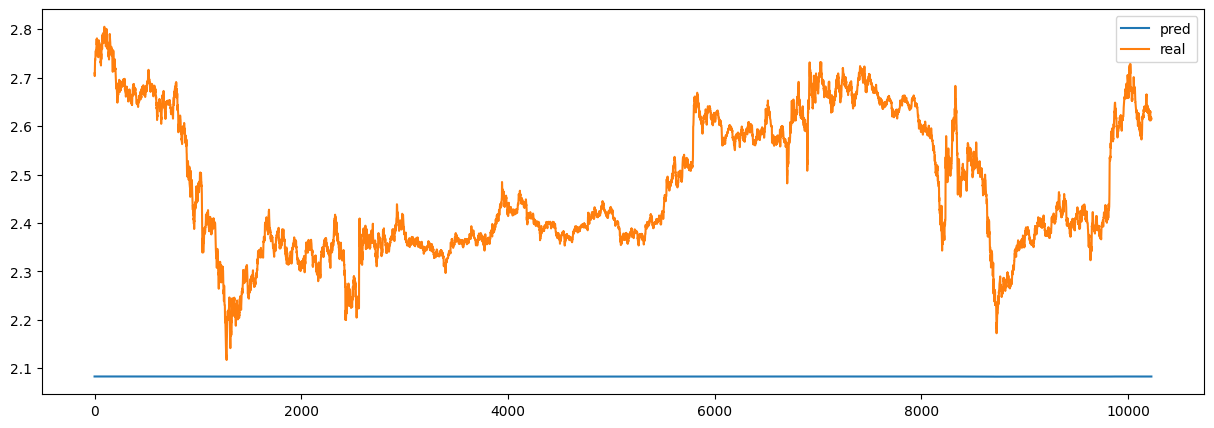

In [6]:
test_df.plot(figsize=(15,5))